# 📈 SmartPortfolio AI - Technical Indicators & Feature Engineering

## Notebook 01b: Calculate Technical Indicators

**Purpose:** Calculate and store technical indicators for all S&P 500 stocks

**Indicators Calculated:**
- Moving Averages (SMA, EMA): 20, 50, 200 day
- RSI (Relative Strength Index)
- MACD (Moving Average Convergence Divergence)
- Bollinger Bands
- ATR (Average True Range)
- Volume Indicators (OBV, Volume SMA)
- Stochastic Oscillator
- ADX (Average Directional Index)

**Output:** Data stored in `market.technical_indicators` table

**Last Updated:** 2024-10-03

In [10]:
# Standard library imports
import sys
from pathlib import Path
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Technical analysis
import ta
from ta.trend import SMAIndicator, EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice

# Database
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Progress tracking
from tqdm.notebook import tqdm

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Load environment variables
load_dotenv(project_root / '.env')

# Import custom modules
from utils.database_connector import DatabaseConnector

print("✅ All libraries imported successfully!")
print(f"📁 Project root: {project_root}")

✅ All libraries imported successfully!
📁 Project root: /Users/RiyanshiKedia/Documents/GitHub/smartportfolio/SmartPortfolio


In [11]:
# Configuration
CONFIG = {
    'BATCH_SIZE': 50,  # Process 50 stocks at a time
    'MIN_DATA_POINTS': 200,  # Minimum trading days required
}

print("📊 Configuration:")
print(f"   Batch Size: {CONFIG['BATCH_SIZE']} stocks")
print(f"   Min Data Points: {CONFIG['MIN_DATA_POINTS']} days")

📊 Configuration:
   Batch Size: 50 stocks
   Min Data Points: 200 days


In [12]:
# Initialize database connection
try:
    db = DatabaseConnector()
    result = db.execute_query("SELECT @@VERSION AS version")
    if not result.empty:
        print("✅ Database connection successful!")
        version = result['version'].iloc[0]
        print(f"   SQL Server: {version[:50]}...")
    else:
        raise Exception("Query returned empty result")
except Exception as e:
    print(f"❌ Connection test failed: {e}")
    sys.exit(1)

2025-10-02 20:22:02,445 - INFO - Attempting connection with pymssql...
2025-10-02 20:22:02,447 - INFO - ✅ Database connection established
2025-10-02 20:22:02,499 - INFO - ✅ Query executed successfully, returned 1 rows


✅ Database connection successful!
   SQL Server: Microsoft SQL Server 2022 (RTM-CU21) (KB5065865) -...


In [13]:
# Create table for technical indicators
create_table_sql = """
-- Drop table if exists (for testing)
IF EXISTS (SELECT * FROM sys.objects WHERE object_id = OBJECT_ID(N'market.technical_indicators') AND type = 'U')
    DROP TABLE market.technical_indicators;

-- Create technical indicators table
CREATE TABLE market.technical_indicators (
    id INT IDENTITY(1,1) PRIMARY KEY,
    ticker VARCHAR(10) NOT NULL,
    date DATE NOT NULL,
    
    -- Moving Averages
    sma_20 DECIMAL(12, 4),
    sma_50 DECIMAL(12, 4),
    sma_200 DECIMAL(12, 4),
    ema_12 DECIMAL(12, 4),
    ema_26 DECIMAL(12, 4),
    
    -- MACD
    macd DECIMAL(12, 4),
    macd_signal DECIMAL(12, 4),
    macd_diff DECIMAL(12, 4),
    
    -- RSI
    rsi_14 DECIMAL(10, 4),
    
    -- Bollinger Bands
    bb_upper DECIMAL(12, 4),
    bb_middle DECIMAL(12, 4),
    bb_lower DECIMAL(12, 4),
    bb_width DECIMAL(12, 4),
    
    -- ATR
    atr_14 DECIMAL(12, 4),
    
    -- Stochastic
    stoch_k DECIMAL(10, 4),
    stoch_d DECIMAL(10, 4),
    
    -- ADX
    adx_14 DECIMAL(10, 4),
    
    -- Volume Indicators
    obv BIGINT,
    volume_sma_20 BIGINT,
    
    -- Price Features
    daily_return DECIMAL(10, 6),
    log_return DECIMAL(10, 6),
    volatility_20 DECIMAL(10, 6),
    
    -- Trend Indicators
    trend_signal VARCHAR(10),  -- 'bullish', 'bearish', 'neutral'
    golden_cross BIT,
    death_cross BIT,
    
    created_at DATETIME DEFAULT GETDATE(),
    
    CONSTRAINT unique_ticker_date_tech UNIQUE (ticker, date),
    CONSTRAINT fk_ticker_tech FOREIGN KEY (ticker) 
        REFERENCES market.sp500_tickers(ticker)
);

-- Create indexes
CREATE INDEX idx_tech_ticker ON market.technical_indicators(ticker);
CREATE INDEX idx_tech_date ON market.technical_indicators(date);
CREATE INDEX idx_tech_ticker_date ON market.technical_indicators(ticker, date);
"""

try:
    with db.engine.begin() as conn:
        conn.execute(text(create_table_sql))
    print("✅ Technical indicators table created successfully!")
except Exception as e:
    print(f"❌ Error creating table: {e}")

✅ Technical indicators table created successfully!


In [16]:
def calculate_technical_indicators(ticker, df):
    """
    Calculate all technical indicators for a single stock
    
    Parameters:
    - ticker: Stock ticker symbol
    - df: DataFrame with columns [date, open, high, low, close, volume]
    
    Returns:
    - DataFrame with all technical indicators
    """
    try:
        # Make a copy and sort by date
        df = df.copy().sort_values('date')
        
        # Ensure we have enough data
        if len(df) < CONFIG['MIN_DATA_POINTS']:
            print(f"   ⚠️  {ticker}: Insufficient data ({len(df)} days)")
            return pd.DataFrame()
        
        # Convert Decimal columns to float (SQL Server returns Decimal)
        numeric_columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Add ticker column
        df['ticker'] = ticker
        
        # ===== MOVING AVERAGES =====
        df['sma_20'] = SMAIndicator(close=df['close'], window=20).sma_indicator()
        df['sma_50'] = SMAIndicator(close=df['close'], window=50).sma_indicator()
        df['sma_200'] = SMAIndicator(close=df['close'], window=200).sma_indicator()
        df['ema_12'] = EMAIndicator(close=df['close'], window=12).ema_indicator()
        df['ema_26'] = EMAIndicator(close=df['close'], window=26).ema_indicator()
        
        # ===== MACD =====
        macd = MACD(close=df['close'])
        df['macd'] = macd.macd()
        df['macd_signal'] = macd.macd_signal()
        df['macd_diff'] = macd.macd_diff()
        
        # ===== RSI =====
        df['rsi_14'] = RSIIndicator(close=df['close'], window=14).rsi()
        
        # ===== BOLLINGER BANDS =====
        bb = BollingerBands(close=df['close'], window=20, window_dev=2)
        df['bb_upper'] = bb.bollinger_hband()
        df['bb_middle'] = bb.bollinger_mavg()
        df['bb_lower'] = bb.bollinger_lband()
        df['bb_width'] = bb.bollinger_wband()
        
        # ===== ATR (Average True Range) =====
        df['atr_14'] = AverageTrueRange(
            high=df['high'], 
            low=df['low'], 
            close=df['close'], 
            window=14
        ).average_true_range()
        
        # ===== STOCHASTIC OSCILLATOR =====
        stoch = StochasticOscillator(
            high=df['high'],
            low=df['low'],
            close=df['close'],
            window=14,
            smooth_window=3
        )
        df['stoch_k'] = stoch.stoch()
        df['stoch_d'] = stoch.stoch_signal()
        
        # ===== ADX (Average Directional Index) =====
        df['adx_14'] = ADXIndicator(
            high=df['high'],
            low=df['low'],
            close=df['close'],
            window=14
        ).adx()
        
        # ===== VOLUME INDICATORS =====
        df['obv'] = OnBalanceVolumeIndicator(
            close=df['close'],
            volume=df['volume']
        ).on_balance_volume()
        
        df['volume_sma_20'] = df['volume'].rolling(window=20).mean()
        
        # ===== PRICE FEATURES =====
        # Daily returns
        df['daily_return'] = df['close'].pct_change()
        
        # Log returns
        df['log_return'] = np.log(df['close'] / df['close'].shift(1))
        
        # Rolling volatility (20-day)
        df['volatility_20'] = df['daily_return'].rolling(window=20).std()
        
        # ===== TREND INDICATORS =====
        # Trend signal based on SMA crossovers
        df['trend_signal'] = 'neutral'
        df.loc[df['sma_20'] > df['sma_50'], 'trend_signal'] = 'bullish'
        df.loc[df['sma_20'] < df['sma_50'], 'trend_signal'] = 'bearish'
        
        # Golden Cross (50-day MA crosses above 200-day MA)
        df['golden_cross'] = False
        df.loc[(df['sma_50'] > df['sma_200']) & 
               (df['sma_50'].shift(1) <= df['sma_200'].shift(1)), 'golden_cross'] = True
        
        # Death Cross (50-day MA crosses below 200-day MA)
        df['death_cross'] = False
        df.loc[(df['sma_50'] < df['sma_200']) & 
               (df['sma_50'].shift(1) >= df['sma_200'].shift(1)), 'death_cross'] = True
        
        # Select columns for database
        columns = [
            'ticker', 'date',
            'sma_20', 'sma_50', 'sma_200', 'ema_12', 'ema_26',
            'macd', 'macd_signal', 'macd_diff',
            'rsi_14',
            'bb_upper', 'bb_middle', 'bb_lower', 'bb_width',
            'atr_14',
            'stoch_k', 'stoch_d',
            'adx_14',
            'obv', 'volume_sma_20',
            'daily_return', 'log_return', 'volatility_20',
            'trend_signal', 'golden_cross', 'death_cross'
        ]
        
        result = df[columns].copy()
        
        # Convert boolean to int for SQL Server
        result['golden_cross'] = result['golden_cross'].astype(int)
        result['death_cross'] = result['death_cross'].astype(int)
        
        # Drop rows with NaN (usually first 200 days due to SMA 200)
        result = result.dropna()
        
        return result
        
    except Exception as e:
        print(f"   ❌ Error calculating indicators for {ticker}: {e}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()


print("✅ Technical indicator calculation function defined")

✅ Technical indicator calculation function defined


---

## 📊 Calculate Technical Indicators for All Stocks

Process all stocks in batches and calculate indicators.

In [17]:
# Get list of all tickers
query_tickers = "SELECT ticker FROM market.sp500_tickers WHERE is_active = 1 ORDER BY ticker"
tickers_df = db.execute_query(query_tickers)
all_tickers = tickers_df['ticker'].tolist()

print(f"🚀 Starting technical indicator calculation for {len(all_tickers)} stocks")
print(f"📦 Batch size: {CONFIG['BATCH_SIZE']}")
print("-" * 60)

# Initialize tracking
all_indicators = []
successful_tickers = []
failed_tickers = []

# Process in batches
num_batches = (len(all_tickers) + CONFIG['BATCH_SIZE'] - 1) // CONFIG['BATCH_SIZE']

for i in tqdm(range(0, len(all_tickers), CONFIG['BATCH_SIZE']), desc="📊 Processing batches"):
    batch_num = (i // CONFIG['BATCH_SIZE']) + 1
    batch_tickers = all_tickers[i:i + CONFIG['BATCH_SIZE']]
    
    print(f"\n🔄 Batch {batch_num}/{num_batches}: {len(batch_tickers)} tickers")
    
    for ticker in batch_tickers:
        try:
            # Fetch price data for this ticker
            query = f"""
                SELECT date, [open], high, low, [close], adj_close, volume
                FROM market.daily_prices
                WHERE ticker = '{ticker}'
                ORDER BY date
            """
            
            df_price = db.execute_query(query)
            
            if df_price.empty:
                failed_tickers.append(ticker)
                print(f"   ⚠️  {ticker}: No price data found")
                continue
            
            # Calculate indicators
            df_indicators = calculate_technical_indicators(ticker, df_price)
            
            if not df_indicators.empty:
                all_indicators.append(df_indicators)
                successful_tickers.append(ticker)
                print(f"   ✅ {ticker}: {len(df_indicators)} indicators calculated")
            else:
                failed_tickers.append(ticker)
                
        except Exception as e:
            failed_tickers.append(ticker)
            print(f"   ❌ {ticker}: Error - {e}")

# Combine all indicators
if all_indicators:
    final_indicators_df = pd.concat(all_indicators, ignore_index=True)
    print(f"\n✅ Technical indicators calculation complete!")
    print(f"   Total indicator records: {len(final_indicators_df):,}")
    print(f"   Successful tickers: {len(successful_tickers)}")
    print(f"   Failed tickers: {len(failed_tickers)}")
else:
    final_indicators_df = pd.DataFrame()
    print("\n❌ No indicators calculated")

2025-10-02 20:23:48,055 - INFO - ✅ Query executed successfully, returned 503 rows


🚀 Starting technical indicator calculation for 503 stocks
📦 Batch size: 50
------------------------------------------------------------


📊 Processing batches:   0%|          | 0/11 [00:00<?, ?it/s]

2025-10-02 20:23:48,072 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,100 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,119 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,138 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,155 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,172 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,186 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,201 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,212 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,225 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,237 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,251 - INFO - ✅ Query executed successfully, returned 250 rows



🔄 Batch 1/11: 50 tickers
   ✅ A: 51 indicators calculated
   ✅ AAPL: 51 indicators calculated
   ✅ ABBV: 51 indicators calculated
   ✅ ABNB: 51 indicators calculated
   ✅ ABT: 51 indicators calculated
   ✅ ACGL: 51 indicators calculated
   ✅ ACN: 51 indicators calculated
   ✅ ADBE: 51 indicators calculated
   ✅ ADI: 51 indicators calculated
   ✅ ADM: 51 indicators calculated
   ✅ ADP: 51 indicators calculated
   ✅ ADSK: 51 indicators calculated


2025-10-02 20:23:48,263 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,286 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,299 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,311 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,323 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,334 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,345 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,355 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,365 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,415 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,447 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,469 - INFO - ✅ Query executed successfully, returned 250 rows


   ✅ AEE: 51 indicators calculated
   ✅ AEP: 51 indicators calculated
   ✅ AES: 51 indicators calculated
   ✅ AFL: 51 indicators calculated
   ✅ AIG: 51 indicators calculated
   ✅ AIZ: 51 indicators calculated
   ✅ AJG: 51 indicators calculated
   ✅ AKAM: 51 indicators calculated
   ✅ ALB: 51 indicators calculated
   ✅ ALGN: 51 indicators calculated
   ✅ ALL: 51 indicators calculated


2025-10-02 20:23:48,486 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,502 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,517 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,534 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,548 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,563 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,577 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,590 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,605 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,620 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,635 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,648 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ ALLE: 51 indicators calculated
   ✅ AMAT: 51 indicators calculated
   ✅ AMCR: 51 indicators calculated
   ✅ AMD: 51 indicators calculated
   ✅ AME: 51 indicators calculated
   ✅ AMGN: 51 indicators calculated
   ✅ AMP: 51 indicators calculated
   ✅ AMT: 51 indicators calculated
   ✅ AMZN: 51 indicators calculated
   ✅ ANET: 51 indicators calculated
   ✅ AON: 51 indicators calculated
   ✅ AOS: 51 indicators calculated
   ✅ APA: 51 indicators calculated
   ✅ APD: 51 indicators calculated


2025-10-02 20:23:48,691 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,705 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,719 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,745 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,756 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,767 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,777 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,787 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,797 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,808 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,818 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,829 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ APH: 51 indicators calculated
   ✅ APO: 51 indicators calculated
   ✅ APP: 51 indicators calculated
   ✅ APTV: 51 indicators calculated
   ✅ ARE: 51 indicators calculated
   ✅ ATO: 51 indicators calculated
   ✅ AVB: 51 indicators calculated
   ✅ AVGO: 51 indicators calculated
   ✅ AVY: 51 indicators calculated
   ✅ AWK: 51 indicators calculated
   ✅ AXON: 51 indicators calculated
   ✅ AXP: 51 indicators calculated
   ✅ AZO: 51 indicators calculated

🔄 Batch 2/11: 50 tickers
   ✅ BA: 51 indicators calculated
   ✅ BAC: 51 indicators calculated
   ✅ BALL: 51 indicators calculated


2025-10-02 20:23:48,893 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,905 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,917 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,929 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,941 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,954 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,968 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,980 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:48,992 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,007 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,023 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,036 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ BAX: 51 indicators calculated
   ✅ BBY: 51 indicators calculated
   ✅ BDX: 51 indicators calculated
   ✅ BEN: 51 indicators calculated
   ✅ BF-B: 51 indicators calculated
   ✅ BG: 51 indicators calculated
   ✅ BIIB: 51 indicators calculated
   ✅ BK: 51 indicators calculated
   ✅ BKNG: 51 indicators calculated
   ✅ BKR: 51 indicators calculated
   ✅ BLDR: 51 indicators calculated
   ✅ BLK: 51 indicators calculated
   ✅ BMY: 51 indicators calculated
   ✅ BR: 51 indicators calculated
   ✅ BRK-B: 51 indicators calculated
   ✅ BRO: 51 indicators calculated


2025-10-02 20:23:49,090 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,104 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,120 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,135 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,148 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,161 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,176 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,189 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,200 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,210 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,221 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,242 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ BSX: 51 indicators calculated
   ✅ BX: 51 indicators calculated
   ✅ BXP: 51 indicators calculated
   ✅ C: 51 indicators calculated
   ✅ CAG: 51 indicators calculated
   ✅ CAH: 51 indicators calculated
   ✅ CARR: 51 indicators calculated
   ✅ CAT: 51 indicators calculated
   ✅ CB: 51 indicators calculated
   ✅ CBOE: 51 indicators calculated
   ✅ CBRE: 51 indicators calculated
   ✅ CCI: 51 indicators calculated
   ✅ CCL: 51 indicators calculated
   ✅ CDNS: 51 indicators calculated
   ✅ CDW: 51 indicators calculated
   ✅ CEG: 51 indicators calculated


2025-10-02 20:23:49,306 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,318 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,333 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,346 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,360 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,371 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,385 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,400 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,412 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,424 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,437 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,452 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ CF: 51 indicators calculated
   ✅ CFG: 51 indicators calculated
   ✅ CHD: 51 indicators calculated
   ✅ CHRW: 51 indicators calculated
   ✅ CHTR: 51 indicators calculated
   ✅ CI: 51 indicators calculated
   ✅ CINF: 51 indicators calculated
   ✅ CL: 51 indicators calculated
   ✅ CLX: 51 indicators calculated
   ✅ CMCSA: 51 indicators calculated
   ✅ CME: 51 indicators calculated
   ✅ CMG: 51 indicators calculated
   ✅ CMI: 51 indicators calculated
   ✅ CMS: 51 indicators calculated
   ✅ CNC: 51 indicators calculated

🔄 Batch 3/11: 50 tickers


2025-10-02 20:23:49,509 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,522 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,536 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,551 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,564 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,576 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,587 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,600 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,612 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,624 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,636 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,650 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ CNP: 51 indicators calculated
   ✅ COF: 51 indicators calculated
   ✅ COIN: 51 indicators calculated
   ✅ COO: 51 indicators calculated
   ✅ COP: 51 indicators calculated
   ✅ COR: 51 indicators calculated
   ✅ COST: 51 indicators calculated
   ✅ CPAY: 51 indicators calculated
   ✅ CPB: 51 indicators calculated
   ✅ CPRT: 51 indicators calculated
   ✅ CPT: 51 indicators calculated
   ✅ CRL: 51 indicators calculated
   ✅ CRM: 51 indicators calculated
   ✅ CRWD: 51 indicators calculated
   ✅ CSCO: 51 indicators calculated


2025-10-02 20:23:49,710 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,722 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,733 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,745 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,756 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,767 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,777 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,788 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,798 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,811 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,822 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,835 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ CSGP: 51 indicators calculated
   ✅ CSX: 51 indicators calculated
   ✅ CTAS: 51 indicators calculated
   ✅ CTRA: 51 indicators calculated
   ✅ CTSH: 51 indicators calculated
   ✅ CTVA: 51 indicators calculated
   ✅ CVS: 51 indicators calculated
   ✅ CVX: 51 indicators calculated
   ✅ D: 51 indicators calculated
   ✅ DAL: 51 indicators calculated
   ✅ DASH: 51 indicators calculated
   ✅ DAY: 51 indicators calculated
   ✅ DD: 51 indicators calculated
   ✅ DDOG: 51 indicators calculated
   ✅ DE: 51 indicators calculated
   ✅ DECK: 51 indicators calculated
   ✅ DELL: 51 indicators calculated


2025-10-02 20:23:49,914 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,928 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,941 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,954 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,967 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,979 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:49,993 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,007 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,019 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,034 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,048 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,061 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ DG: 51 indicators calculated
   ✅ DGX: 51 indicators calculated
   ✅ DHI: 51 indicators calculated
   ✅ DHR: 51 indicators calculated
   ✅ DIS: 51 indicators calculated
   ✅ DLR: 51 indicators calculated
   ✅ DLTR: 51 indicators calculated
   ✅ DOC: 51 indicators calculated
   ✅ DOV: 51 indicators calculated
   ✅ DOW: 51 indicators calculated
   ✅ DPZ: 51 indicators calculated
   ✅ DRI: 51 indicators calculated
   ✅ DTE: 51 indicators calculated
   ✅ DUK: 51 indicators calculated
   ✅ DVA: 51 indicators calculated
   ✅ DVN: 51 indicators calculated


2025-10-02 20:23:50,121 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,133 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,194 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,233 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,257 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,273 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,287 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,300 - INFO - ✅ Query executed successfully, returned 250 rows


   ✅ DXCM: 51 indicators calculated
   ✅ EA: 51 indicators calculated

🔄 Batch 4/11: 50 tickers
   ✅ EBAY: 51 indicators calculated
   ✅ ECL: 51 indicators calculated
   ✅ ED: 51 indicators calculated
   ✅ EFX: 51 indicators calculated
   ✅ EG: 51 indicators calculated
   ✅ EIX: 51 indicators calculated
   ✅ EL: 51 indicators calculated


2025-10-02 20:23:50,317 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,329 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,342 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,353 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,364 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,375 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,386 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,398 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,410 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,421 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,433 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,446 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ ELV: 51 indicators calculated
   ✅ EME: 51 indicators calculated
   ✅ EMN: 51 indicators calculated
   ✅ EMR: 51 indicators calculated
   ✅ EOG: 51 indicators calculated
   ✅ EPAM: 51 indicators calculated
   ✅ EQIX: 51 indicators calculated
   ✅ EQR: 51 indicators calculated
   ✅ EQT: 51 indicators calculated
   ✅ ERIE: 51 indicators calculated
   ✅ ES: 51 indicators calculated
   ✅ ESS: 51 indicators calculated
   ✅ ETN: 51 indicators calculated
   ✅ ETR: 51 indicators calculated
   ✅ EVRG: 51 indicators calculated
   ✅ EW: 51 indicators calculated
   ✅ EXC: 51 indicators calculated
   ✅ EXE: 51 indicators calculated


2025-10-02 20:23:50,528 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,540 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,554 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,565 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,580 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,590 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,603 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,615 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,625 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,636 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,648 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,661 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ EXPD: 51 indicators calculated
   ✅ EXPE: 51 indicators calculated
   ✅ EXR: 51 indicators calculated
   ✅ F: 51 indicators calculated
   ✅ FANG: 51 indicators calculated
   ✅ FAST: 51 indicators calculated
   ✅ FCX: 51 indicators calculated
   ✅ FDS: 51 indicators calculated
   ✅ FDX: 51 indicators calculated
   ✅ FE: 51 indicators calculated
   ✅ FFIV: 51 indicators calculated
   ✅ FI: 51 indicators calculated
   ✅ FICO: 51 indicators calculated
   ✅ FIS: 51 indicators calculated
   ✅ FITB: 51 indicators calculated
   ✅ FOX: 51 indicators calculated
   ✅ FOXA: 51 indicators calculated


2025-10-02 20:23:50,747 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,765 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,776 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,788 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,800 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,814 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,825 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,836 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,846 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,859 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,872 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,885 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ FRT: 51 indicators calculated
   ✅ FSLR: 51 indicators calculated
   ✅ FTNT: 51 indicators calculated
   ✅ FTV: 51 indicators calculated
   ✅ GD: 51 indicators calculated
   ✅ GDDY: 51 indicators calculated
   ✅ GE: 51 indicators calculated
   ✅ GEHC: 51 indicators calculated

🔄 Batch 5/11: 50 tickers
   ✅ GEN: 51 indicators calculated
   ✅ GEV: 51 indicators calculated
   ✅ GILD: 51 indicators calculated
   ✅ GIS: 51 indicators calculated
   ✅ GL: 51 indicators calculated
   ✅ GLW: 51 indicators calculated
   ✅ GM: 51 indicators calculated
   ✅ GNRC: 51 indicators calculated


2025-10-02 20:23:50,948 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,960 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,973 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,985 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:50,997 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,008 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,020 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,031 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,044 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,055 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,067 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,081 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ GOOG: 51 indicators calculated
   ✅ GOOGL: 51 indicators calculated
   ✅ GPC: 51 indicators calculated
   ✅ GPN: 51 indicators calculated
   ✅ GRMN: 51 indicators calculated
   ✅ GS: 51 indicators calculated
   ✅ GWW: 51 indicators calculated
   ✅ HAL: 51 indicators calculated
   ✅ HAS: 51 indicators calculated
   ✅ HBAN: 51 indicators calculated
   ✅ HCA: 51 indicators calculated
   ✅ HD: 51 indicators calculated
   ✅ HIG: 51 indicators calculated
   ✅ HII: 51 indicators calculated
   ✅ HLT: 51 indicators calculated
   ✅ HOLX: 51 indicators calculated
   ✅ HON: 51 indicators calculated


2025-10-02 20:23:51,155 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,168 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,179 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,190 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,202 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,214 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,228 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,240 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,250 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,261 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,273 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,285 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ HOOD: 51 indicators calculated
   ✅ HPE: 51 indicators calculated
   ✅ HPQ: 51 indicators calculated
   ✅ HRL: 51 indicators calculated
   ✅ HSIC: 51 indicators calculated
   ✅ HST: 51 indicators calculated
   ✅ HSY: 51 indicators calculated
   ✅ HUBB: 51 indicators calculated
   ✅ HUM: 51 indicators calculated
   ✅ HWM: 51 indicators calculated
   ✅ IBKR: 51 indicators calculated
   ✅ IBM: 51 indicators calculated
   ✅ ICE: 51 indicators calculated
   ✅ IDXX: 51 indicators calculated
   ✅ IEX: 51 indicators calculated
   ✅ IFF: 51 indicators calculated
   ✅ INCY: 51 indicators calculated


2025-10-02 20:23:51,359 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,373 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,387 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,402 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,414 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,427 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,438 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,457 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,467 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,477 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,489 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,500 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ INTC: 51 indicators calculated
   ✅ INTU: 51 indicators calculated
   ✅ INVH: 51 indicators calculated
   ✅ IP: 51 indicators calculated
   ✅ IPG: 51 indicators calculated
   ✅ IQV: 51 indicators calculated
   ✅ IR: 51 indicators calculated
   ✅ IRM: 51 indicators calculated

🔄 Batch 6/11: 50 tickers
   ✅ ISRG: 51 indicators calculated
   ✅ IT: 51 indicators calculated
   ✅ ITW: 51 indicators calculated
   ✅ IVZ: 51 indicators calculated
   ✅ J: 51 indicators calculated
   ✅ JBHT: 51 indicators calculated
   ✅ JBL: 51 indicators calculated
   ✅ JCI: 51 indicators calculated
   ✅ JKHY: 51 indicators calculated


2025-10-02 20:23:51,558 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,572 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,593 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,605 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,615 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,632 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,643 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,654 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,665 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,677 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,691 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,702 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ JNJ: 51 indicators calculated
   ✅ JPM: 51 indicators calculated
   ✅ K: 51 indicators calculated
   ✅ KDP: 51 indicators calculated
   ✅ KEY: 51 indicators calculated
   ✅ KEYS: 51 indicators calculated
   ✅ KHC: 51 indicators calculated
   ✅ KIM: 51 indicators calculated
   ✅ KKR: 51 indicators calculated
   ✅ KLAC: 51 indicators calculated
   ✅ KMB: 51 indicators calculated
   ✅ KMI: 51 indicators calculated
   ✅ KMX: 51 indicators calculated
   ✅ KO: 51 indicators calculated
   ✅ KR: 51 indicators calculated
   ✅ KVUE: 51 indicators calculated


2025-10-02 20:23:51,778 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,791 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,805 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,819 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,831 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,842 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,854 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,866 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,888 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,898 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,909 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:51,920 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ L: 51 indicators calculated
   ✅ LDOS: 51 indicators calculated
   ✅ LEN: 51 indicators calculated
   ✅ LH: 51 indicators calculated
   ✅ LHX: 51 indicators calculated
   ✅ LII: 51 indicators calculated
   ✅ LIN: 51 indicators calculated
   ✅ LKQ: 51 indicators calculated
   ✅ LLY: 51 indicators calculated
   ✅ LMT: 51 indicators calculated
   ✅ LNT: 51 indicators calculated
   ✅ LOW: 51 indicators calculated
   ✅ LRCX: 51 indicators calculated
   ✅ LULU: 51 indicators calculated
   ✅ LUV: 51 indicators calculated
   ✅ LVS: 51 indicators calculated
   ✅ LW: 51 indicators calculated


2025-10-02 20:23:51,978 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,021 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,063 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,086 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,097 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,110 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,122 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,132 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,144 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,155 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,166 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,177 - INFO - ✅ Query executed successfully, returned 250 rows


   ✅ LYB: 51 indicators calculated
   ✅ LYV: 51 indicators calculated
   ✅ MA: 51 indicators calculated
   ✅ MAA: 51 indicators calculated
   ✅ MAR: 51 indicators calculated
   ✅ MAS: 51 indicators calculated
   ✅ MCD: 51 indicators calculated
   ✅ MCHP: 51 indicators calculated

🔄 Batch 7/11: 50 tickers
   ✅ MCK: 51 indicators calculated
   ✅ MCO: 51 indicators calculated
   ✅ MDLZ: 51 indicators calculated
   ✅ MDT: 51 indicators calculated


2025-10-02 20:23:52,188 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,200 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,213 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,227 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,240 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,253 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,263 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,277 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,288 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,300 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,314 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,328 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ MET: 51 indicators calculated
   ✅ META: 51 indicators calculated
   ✅ MGM: 51 indicators calculated
   ✅ MHK: 51 indicators calculated
   ✅ MKC: 51 indicators calculated
   ✅ MLM: 51 indicators calculated
   ✅ MMC: 51 indicators calculated
   ✅ MMM: 51 indicators calculated
   ✅ MNST: 51 indicators calculated
   ✅ MO: 51 indicators calculated
   ✅ MOH: 51 indicators calculated
   ✅ MOS: 51 indicators calculated
   ✅ MPC: 51 indicators calculated
   ✅ MPWR: 51 indicators calculated
   ✅ MRK: 51 indicators calculated
   ✅ MRNA: 51 indicators calculated


2025-10-02 20:23:52,407 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,419 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,431 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,443 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,455 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,465 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,479 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,493 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,506 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,516 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,528 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,540 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ MS: 51 indicators calculated
   ✅ MSCI: 51 indicators calculated
   ✅ MSFT: 51 indicators calculated
   ✅ MSI: 51 indicators calculated
   ✅ MTB: 51 indicators calculated
   ✅ MTCH: 51 indicators calculated
   ✅ MTD: 51 indicators calculated
   ✅ MU: 51 indicators calculated
   ✅ NCLH: 51 indicators calculated
   ✅ NDAQ: 51 indicators calculated
   ✅ NDSN: 51 indicators calculated
   ✅ NEE: 51 indicators calculated
   ✅ NEM: 51 indicators calculated
   ✅ NFLX: 51 indicators calculated
   ✅ NI: 51 indicators calculated
   ✅ NKE: 51 indicators calculated


2025-10-02 20:23:52,661 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,679 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,694 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,708 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,724 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,737 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,752 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,766 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,780 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,793 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,806 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,820 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ NOC: 51 indicators calculated
   ✅ NOW: 51 indicators calculated
   ✅ NRG: 51 indicators calculated
   ✅ NSC: 51 indicators calculated
   ✅ NTAP: 51 indicators calculated
   ✅ NTRS: 51 indicators calculated
   ✅ NUE: 51 indicators calculated
   ✅ NVDA: 51 indicators calculated
   ✅ NVR: 51 indicators calculated
   ✅ NWS: 51 indicators calculated
   ✅ NWSA: 51 indicators calculated
   ✅ NXPI: 51 indicators calculated
   ✅ O: 51 indicators calculated
   ✅ ODFL: 51 indicators calculated

🔄 Batch 8/11: 50 tickers


2025-10-02 20:23:52,861 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,875 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,890 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,903 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,914 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,937 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,948 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,961 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,973 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,985 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:52,997 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,009 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ OKE: 51 indicators calculated
   ✅ OMC: 51 indicators calculated
   ✅ ON: 51 indicators calculated
   ✅ ORCL: 51 indicators calculated
   ✅ ORLY: 51 indicators calculated
   ✅ OTIS: 51 indicators calculated
   ✅ OXY: 51 indicators calculated
   ✅ PANW: 51 indicators calculated
   ✅ PAYC: 51 indicators calculated
   ✅ PAYX: 51 indicators calculated
   ✅ PCAR: 51 indicators calculated
   ✅ PCG: 51 indicators calculated
   ✅ PEG: 51 indicators calculated
   ✅ PEP: 51 indicators calculated
   ✅ PFE: 51 indicators calculated


2025-10-02 20:23:53,057 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,068 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,080 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,092 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,102 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,113 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,125 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,138 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,150 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,164 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,178 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,191 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ PFG: 51 indicators calculated
   ✅ PG: 51 indicators calculated
   ✅ PGR: 51 indicators calculated
   ✅ PH: 51 indicators calculated
   ✅ PHM: 51 indicators calculated
   ✅ PKG: 51 indicators calculated
   ✅ PLD: 51 indicators calculated
   ✅ PLTR: 51 indicators calculated
   ✅ PM: 51 indicators calculated
   ✅ PNC: 51 indicators calculated
   ✅ PNR: 51 indicators calculated
   ✅ PNW: 51 indicators calculated
   ✅ PODD: 51 indicators calculated
   ✅ POOL: 51 indicators calculated
   ✅ PPG: 51 indicators calculated
   ✅ PPL: 51 indicators calculated
   ✅ PRU: 51 indicators calculated


2025-10-02 20:23:53,274 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,288 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,303 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,317 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,331 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,344 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,358 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,370 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,385 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,398 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,410 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,422 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ PSA: 51 indicators calculated
   ✅ PSKY: 51 indicators calculated
   ✅ PSX: 51 indicators calculated
   ✅ PTC: 51 indicators calculated
   ✅ PWR: 51 indicators calculated
   ✅ PYPL: 51 indicators calculated
   ✅ QCOM: 51 indicators calculated
   ✅ RCL: 51 indicators calculated
   ✅ REG: 51 indicators calculated
   ✅ REGN: 51 indicators calculated
   ✅ RF: 51 indicators calculated
   ✅ RJF: 51 indicators calculated
   ✅ RL: 51 indicators calculated
   ✅ RMD: 51 indicators calculated
   ✅ ROK: 51 indicators calculated
   ✅ ROL: 51 indicators calculated


2025-10-02 20:23:53,479 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,492 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,506 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,525 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,538 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,549 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,561 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,573 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,587 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,601 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,614 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,627 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ ROP: 51 indicators calculated
   ✅ ROST: 51 indicators calculated

🔄 Batch 9/11: 50 tickers
   ✅ RSG: 51 indicators calculated
   ✅ RTX: 51 indicators calculated
   ✅ RVTY: 51 indicators calculated
   ✅ SBAC: 51 indicators calculated
   ✅ SBUX: 51 indicators calculated
   ✅ SCHW: 51 indicators calculated
   ✅ SHW: 51 indicators calculated
   ✅ SJM: 51 indicators calculated
   ✅ SLB: 51 indicators calculated
   ✅ SMCI: 51 indicators calculated
   ✅ SNA: 51 indicators calculated
   ✅ SNPS: 51 indicators calculated
   ✅ SO: 51 indicators calculated


2025-10-02 20:23:53,688 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,703 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,718 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,732 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,744 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,758 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,771 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,785 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,799 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,811 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,825 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,838 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ SOLV: 51 indicators calculated
   ✅ SPG: 51 indicators calculated
   ✅ SPGI: 51 indicators calculated
   ✅ SRE: 51 indicators calculated
   ✅ STE: 51 indicators calculated
   ✅ STLD: 51 indicators calculated
   ✅ STT: 51 indicators calculated
   ✅ STX: 51 indicators calculated
   ✅ STZ: 51 indicators calculated
   ✅ SW: 51 indicators calculated
   ✅ SWK: 51 indicators calculated
   ✅ SWKS: 51 indicators calculated
   ✅ SYF: 51 indicators calculated
   ✅ SYK: 51 indicators calculated


2025-10-02 20:23:53,954 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,974 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:53,990 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,002 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,014 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,025 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,039 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,050 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,062 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,076 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,089 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,102 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ SYY: 51 indicators calculated
   ✅ T: 51 indicators calculated
   ✅ TAP: 51 indicators calculated
   ✅ TDG: 51 indicators calculated
   ✅ TDY: 51 indicators calculated
   ✅ TECH: 51 indicators calculated
   ✅ TEL: 51 indicators calculated
   ✅ TER: 51 indicators calculated
   ✅ TFC: 51 indicators calculated
   ✅ TGT: 51 indicators calculated
   ✅ TJX: 51 indicators calculated
   ✅ TKO: 51 indicators calculated
   ✅ TMO: 51 indicators calculated
   ✅ TMUS: 51 indicators calculated


2025-10-02 20:23:54,141 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,155 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,174 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,187 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,199 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,211 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,223 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,236 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,249 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,263 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,276 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,289 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ TPL: 51 indicators calculated
   ✅ TPR: 51 indicators calculated
   ✅ TRGP: 51 indicators calculated
   ✅ TRMB: 51 indicators calculated
   ✅ TROW: 51 indicators calculated
   ✅ TRV: 51 indicators calculated
   ✅ TSCO: 51 indicators calculated
   ✅ TSLA: 51 indicators calculated
   ✅ TSN: 51 indicators calculated

🔄 Batch 10/11: 50 tickers
   ✅ TT: 51 indicators calculated
   ✅ TTD: 51 indicators calculated
   ✅ TTWO: 51 indicators calculated
   ✅ TXN: 51 indicators calculated
   ✅ TXT: 51 indicators calculated
   ✅ TYL: 51 indicators calculated


2025-10-02 20:23:54,344 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,358 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,373 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,387 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,402 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,417 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,430 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,443 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,456 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,469 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,484 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,496 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ UAL: 51 indicators calculated
   ✅ UBER: 51 indicators calculated
   ✅ UDR: 51 indicators calculated
   ✅ UHS: 51 indicators calculated
   ✅ ULTA: 51 indicators calculated
   ✅ UNH: 51 indicators calculated
   ✅ UNP: 51 indicators calculated
   ✅ UPS: 51 indicators calculated
   ✅ URI: 51 indicators calculated
   ✅ USB: 51 indicators calculated
   ✅ V: 51 indicators calculated
   ✅ VICI: 51 indicators calculated
   ✅ VLO: 51 indicators calculated
   ✅ VLTO: 51 indicators calculated
   ✅ VMC: 51 indicators calculated


2025-10-02 20:23:54,550 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,563 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,576 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,588 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,601 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,612 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,626 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,640 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,653 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,667 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,688 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,700 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ VRSK: 51 indicators calculated
   ✅ VRSN: 51 indicators calculated
   ✅ VRTX: 51 indicators calculated
   ✅ VST: 51 indicators calculated
   ✅ VTR: 51 indicators calculated
   ✅ VTRS: 51 indicators calculated
   ✅ VZ: 51 indicators calculated
   ✅ WAB: 51 indicators calculated
   ✅ WAT: 51 indicators calculated
   ✅ WBD: 51 indicators calculated
   ✅ WDAY: 51 indicators calculated
   ✅ WDC: 51 indicators calculated
   ✅ WEC: 51 indicators calculated
   ✅ WELL: 51 indicators calculated
   ✅ WFC: 51 indicators calculated
   ✅ WM: 51 indicators calculated


2025-10-02 20:23:54,747 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,765 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,780 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,791 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,803 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,814 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,826 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,839 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,851 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,864 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,875 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23:54,887 - INFO - ✅ Query executed successfully, returned 250 rows
2025-10-02 20:23

   ✅ WMB: 51 indicators calculated
   ✅ WMT: 51 indicators calculated
   ✅ WRB: 51 indicators calculated
   ✅ WSM: 51 indicators calculated
   ✅ WST: 51 indicators calculated
   ✅ WTW: 51 indicators calculated
   ✅ WY: 51 indicators calculated
   ✅ WYNN: 51 indicators calculated
   ✅ XEL: 51 indicators calculated
   ✅ XOM: 51 indicators calculated
   ✅ XYL: 51 indicators calculated
   ✅ XYZ: 51 indicators calculated
   ✅ YUM: 51 indicators calculated

🔄 Batch 11/11: 3 tickers
   ✅ ZBH: 51 indicators calculated
   ✅ ZBRA: 51 indicators calculated
   ✅ ZTS: 51 indicators calculated

✅ Technical indicators calculation complete!
   Total indicator records: 25,653
   Successful tickers: 503
   Failed tickers: 0


In [20]:
# Display sample of calculated indicators with prices
if not final_indicators_df.empty:
    print("📊 Sample of calculated technical indicators:")
    print("\n" + "="*80)
    
    # Show sample for one ticker
    sample_ticker = final_indicators_df['ticker'].iloc[0]
    
    # Query to get both price and indicators
    query_sample = f"""
        SELECT 
            t.date,
            p.[close],
            t.sma_20,
            t.sma_50,
            t.rsi_14,
            t.macd,
            t.trend_signal
        FROM market.technical_indicators t
        JOIN market.daily_prices p ON t.ticker = p.ticker AND t.date = p.date
        WHERE t.ticker = '{sample_ticker}'
        ORDER BY t.date DESC
    """
    
    try:
        sample_with_price = db.execute_query(query_sample)
        
        if not sample_with_price.empty:
            print(f"\n📈 {sample_ticker} - Latest 10 days (with price):")
            print(sample_with_price.head(10).to_string(index=False))
        else:
            # Fallback to showing just indicators
            sample_df = final_indicators_df[final_indicators_df['ticker'] == sample_ticker].tail(10)
            display_cols = ['date', 'sma_20', 'sma_50', 'rsi_14', 'macd', 'trend_signal']
            print(f"\n📈 {sample_ticker} - Latest 10 days:")
            print(sample_df[display_cols].to_string(index=False))
    except Exception as e:
        print(f"⚠️  Could not query with price: {e}")
        # Show just indicators
        sample_df = final_indicators_df[final_indicators_df['ticker'] == sample_ticker].tail(10)
        display_cols = ['date', 'sma_20', 'sma_50', 'rsi_14', 'macd', 'trend_signal']
        print(f"\n📈 {sample_ticker} - Latest 10 days:")
        print(sample_df[display_cols].to_string(index=False))
    
    print("\n📊 Data Info:")
    print(f"   Total records: {len(final_indicators_df):,}")
    print(f"   Date range: {final_indicators_df['date'].min()} to {final_indicators_df['date'].max()}")
    print(f"   Tickers: {final_indicators_df['ticker'].nunique()}")
    
    print("\n📊 Indicator Statistics:")
    stats_cols = ['sma_20', 'sma_50', 'rsi_14', 'macd', 'volatility_20']
    print(final_indicators_df[stats_cols].describe())
    
else:
    print("❌ No indicators to display")

2025-10-02 20:25:20,661 - INFO - ✅ Query executed successfully, returned 0 rows


📊 Sample of calculated technical indicators:


📈 A - Latest 10 days:
      date     sma_20     sma_50    rsi_14     macd trend_signal
2025-09-18 124.192110 119.875086 59.246381 2.088205      bullish
2025-09-19 124.649690 119.917998 55.949492 1.978084      bullish
2025-09-22 124.884220 119.978876 55.969828 1.870062      bullish
2025-09-23 125.223040 120.095840 54.907381 1.733070      bullish
2025-09-24 125.526430 120.324180 50.756699 1.481794      bullish
2025-09-25 125.686110 120.493040 44.919863 1.069804      bullish
2025-09-26 125.607765 120.633358 48.743799 0.854248      bullish
2025-09-29 125.512455 120.828166 49.647361 0.704292      bullish
2025-09-30 125.682000 121.158856 59.915243 0.965514      bullish
2025-10-01 126.362545 121.611312 72.608482 1.975241      bullish

📊 Data Info:
   Total records: 25,653
   Date range: 2025-07-22 to 2025-10-01
   Tickers: 503

📊 Indicator Statistics:
             sma_20        sma_50        rsi_14          macd  volatility_20
count  25653.000000

In [21]:
# Store technical indicators in database
if not final_indicators_df.empty:
    print("💾 Storing technical indicators in database...")
    print(f"   Table: market.technical_indicators")
    print(f"   Records: {len(final_indicators_df):,}")
    
    try:
        # Clear existing data
        existing_count = db.get_row_count('technical_indicators', schema='market')
        if existing_count > 0:
            print(f"⚠️  Table already has {existing_count:,} records. Clearing...")
            db.truncate_table('technical_indicators', schema='market')
        
        # Insert new data
        success = db.insert_data(
            final_indicators_df,
            table_name='technical_indicators',
            schema='market',
            if_exists='append'
        )
        
        if success:
            print("✅ Technical indicators successfully stored in database!")
            
            # Verify insertion
            total_records = db.get_row_count('technical_indicators', schema='market')
            print(f"📊 Total records in market.technical_indicators: {total_records:,}")
            
            # Get latest date
            latest_date = db.get_latest_date('technical_indicators', schema='market', date_column='date')
            print(f"📅 Latest date in database: {latest_date}")
        else:
            print("❌ Failed to store indicators in database")
    
    except Exception as e:
        print(f"❌ Error storing indicators: {e}")
else:
    print("❌ No indicators to store")

💾 Storing technical indicators in database...
   Table: market.technical_indicators
   Records: 25,653


2025-10-02 20:26:52,565 - INFO - ✅ Inserted 25653 records into market.technical_indicators


✅ Technical indicators successfully stored in database!
📊 Total records in market.technical_indicators: 25,653
📅 Latest date in database: 2025-10-01


---

## ✅ Data Verification & Quality Checks

Verify that indicators were calculated correctly and check for any anomalies.

In [22]:
# Query database for verification
print("📊 DATABASE VERIFICATION")
print("=" * 60)

try:
    # Total records
    query_count = "SELECT COUNT(*) as count FROM market.technical_indicators"
    result = db.execute_query(query_count)
    total_records = result['count'].iloc[0]
    print(f"✓ Total indicator records: {total_records:,}")
    
    # Tickers with indicators
    query_tickers = "SELECT COUNT(DISTINCT ticker) as count FROM market.technical_indicators"
    result = db.execute_query(query_tickers)
    tickers_count = result['count'].iloc[0]
    print(f"✓ Tickers with indicators: {tickers_count}")
    
    # Date range
    query_dates = """
        SELECT 
            MIN(date) as earliest_date,
            MAX(date) as latest_date,
            COUNT(DISTINCT date) as trading_days
        FROM market.technical_indicators
    """
    result = db.execute_query(query_dates)
    print(f"✓ Date range: {result['earliest_date'].iloc[0]} to {result['latest_date'].iloc[0]}")
    print(f"✓ Trading days: {result['trading_days'].iloc[0]}")
    
    # Average indicators per ticker
    avg_records = total_records / tickers_count if tickers_count > 0 else 0
    print(f"✓ Average records per ticker: {avg_records:.0f}")
    
    # Check for null values
    query_nulls = """
        SELECT 
            SUM(CASE WHEN sma_20 IS NULL THEN 1 ELSE 0 END) as null_sma,
            SUM(CASE WHEN rsi_14 IS NULL THEN 1 ELSE 0 END) as null_rsi,
            SUM(CASE WHEN macd IS NULL THEN 1 ELSE 0 END) as null_macd
        FROM market.technical_indicators
    """
    result = db.execute_query(query_nulls)
    print(f"\n📊 Null Value Check:")
    print(f"   SMA nulls: {result['null_sma'].iloc[0]}")
    print(f"   RSI nulls: {result['null_rsi'].iloc[0]}")
    print(f"   MACD nulls: {result['null_macd'].iloc[0]}")
    
    # Golden/Death crosses
    query_crosses = """
        SELECT 
            SUM(CAST(golden_cross AS INT)) as total_golden_cross,
            SUM(CAST(death_cross AS INT)) as total_death_cross
        FROM market.technical_indicators
    """
    result = db.execute_query(query_crosses)
    print(f"\n📊 Market Signals:")
    print(f"   Golden crosses detected: {result['total_golden_cross'].iloc[0]}")
    print(f"   Death crosses detected: {result['total_death_cross'].iloc[0]}")
    
    print("=" * 60)
    
except Exception as e:
    print(f"❌ Error querying database: {e}")

2025-10-02 20:27:08,322 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:27:08,388 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:27:08,400 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:27:08,417 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:27:08,427 - INFO - ✅ Query executed successfully, returned 1 rows


📊 DATABASE VERIFICATION
✓ Total indicator records: 25,653
✓ Tickers with indicators: 503
✓ Date range: 2025-07-22 to 2025-10-01
✓ Trading days: 51
✓ Average records per ticker: 51

📊 Null Value Check:
   SMA nulls: 0
   RSI nulls: 0
   MACD nulls: 0

📊 Market Signals:
   Golden crosses detected: 107
   Death crosses detected: 43


In [23]:
# Analyze indicator distributions
try:
    query_stats = """
        SELECT 
            AVG(rsi_14) as avg_rsi,
            MIN(rsi_14) as min_rsi,
            MAX(rsi_14) as max_rsi,
            AVG(volatility_20) as avg_volatility,
            COUNT(CASE WHEN rsi_14 < 30 THEN 1 END) as oversold_count,
            COUNT(CASE WHEN rsi_14 > 70 THEN 1 END) as overbought_count,
            COUNT(CASE WHEN trend_signal = 'bullish' THEN 1 END) as bullish_count,
            COUNT(CASE WHEN trend_signal = 'bearish' THEN 1 END) as bearish_count,
            COUNT(CASE WHEN trend_signal = 'neutral' THEN 1 END) as neutral_count
        FROM market.technical_indicators
        WHERE date = (SELECT MAX(date) FROM market.technical_indicators)
    """
    
    stats = db.execute_query(query_stats)
    
    print("📊 LATEST MARKET INDICATORS (Most Recent Date)")
    print("=" * 60)
    print(f"RSI Statistics:")
    print(f"   Average RSI: {stats['avg_rsi'].iloc[0]:.2f}")
    print(f"   Min RSI: {stats['min_rsi'].iloc[0]:.2f}")
    print(f"   Max RSI: {stats['max_rsi'].iloc[0]:.2f}")
    print(f"   Oversold (RSI < 30): {stats['oversold_count'].iloc[0]} stocks")
    print(f"   Overbought (RSI > 70): {stats['overbought_count'].iloc[0]} stocks")
    
    print(f"\nAverage Volatility (20-day): {stats['avg_volatility'].iloc[0]:.4f}")
    
    print(f"\nTrend Distribution:")
    print(f"   Bullish: {stats['bullish_count'].iloc[0]} stocks")
    print(f"   Bearish: {stats['bearish_count'].iloc[0]} stocks")
    print(f"   Neutral: {stats['neutral_count'].iloc[0]} stocks")
    print("=" * 60)
    
except Exception as e:
    print(f"❌ Error analyzing indicators: {e}")

2025-10-02 20:27:13,717 - INFO - ✅ Query executed successfully, returned 1 rows


📊 LATEST MARKET INDICATORS (Most Recent Date)
RSI Statistics:
   Average RSI: 52.52
   Min RSI: 21.40
   Max RSI: 86.31
   Oversold (RSI < 30): 17 stocks
   Overbought (RSI > 70): 48 stocks

Average Volatility (20-day): 0.0163

Trend Distribution:
   Bullish: 297 stocks
   Bearish: 206 stocks
   Neutral: 0 stocks


---

## 📊 Visualize Technical Indicators

Create charts to visualize indicator performance and distributions.

2025-10-02 20:27:20,169 - INFO - ✅ Query executed successfully, returned 503 rows


❌ Error visualizing RSI: unsupported operand type(s) for *: 'decimal.Decimal' and 'float'


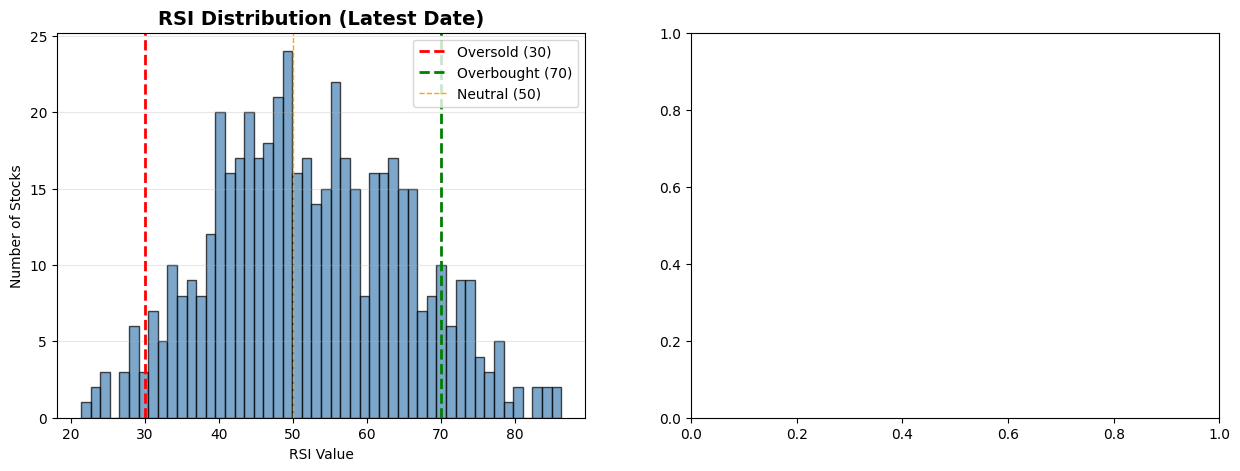

In [24]:
# Visualize RSI distribution
try:
    query_rsi = """
        SELECT ticker, rsi_14
        FROM market.technical_indicators
        WHERE date = (SELECT MAX(date) FROM market.technical_indicators)
        AND rsi_14 IS NOT NULL
        ORDER BY rsi_14
    """
    
    rsi_df = db.execute_query(query_rsi)
    
    if not rsi_df.empty:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogram
        axes[0].hist(rsi_df['rsi_14'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        axes[0].axvline(30, color='red', linestyle='--', linewidth=2, label='Oversold (30)')
        axes[0].axvline(70, color='green', linestyle='--', linewidth=2, label='Overbought (70)')
        axes[0].axvline(50, color='orange', linestyle='--', linewidth=1, label='Neutral (50)')
        axes[0].set_xlabel('RSI Value')
        axes[0].set_ylabel('Number of Stocks')
        axes[0].set_title('RSI Distribution (Latest Date)', fontsize=14, fontweight='bold')
        axes[0].legend()
        axes[0].grid(axis='y', alpha=0.3)
        
        # Box plot
        axes[1].boxplot(rsi_df['rsi_14'], vert=True)
        axes[1].axhline(30, color='red', linestyle='--', linewidth=2, alpha=0.5)
        axes[1].axhline(70, color='green', linestyle='--', linewidth=2, alpha=0.5)
        axes[1].set_ylabel('RSI Value')
        axes[1].set_title('RSI Box Plot', fontsize=14, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print extreme RSI stocks
        print("\n📊 Oversold Stocks (RSI < 30):")
        oversold = rsi_df[rsi_df['rsi_14'] < 30].head(10)
        if not oversold.empty:
            print(oversold.to_string(index=False))
        else:
            print("   None")
        
        print("\n📊 Overbought Stocks (RSI > 70):")
        overbought = rsi_df[rsi_df['rsi_14'] > 70].head(10)
        if not overbought.empty:
            print(overbought.to_string(index=False))
        else:
            print("   None")
    
except Exception as e:
    print(f"❌ Error visualizing RSI: {e}")

2025-10-02 20:27:58,976 - INFO - ✅ Query executed successfully, returned 51 rows


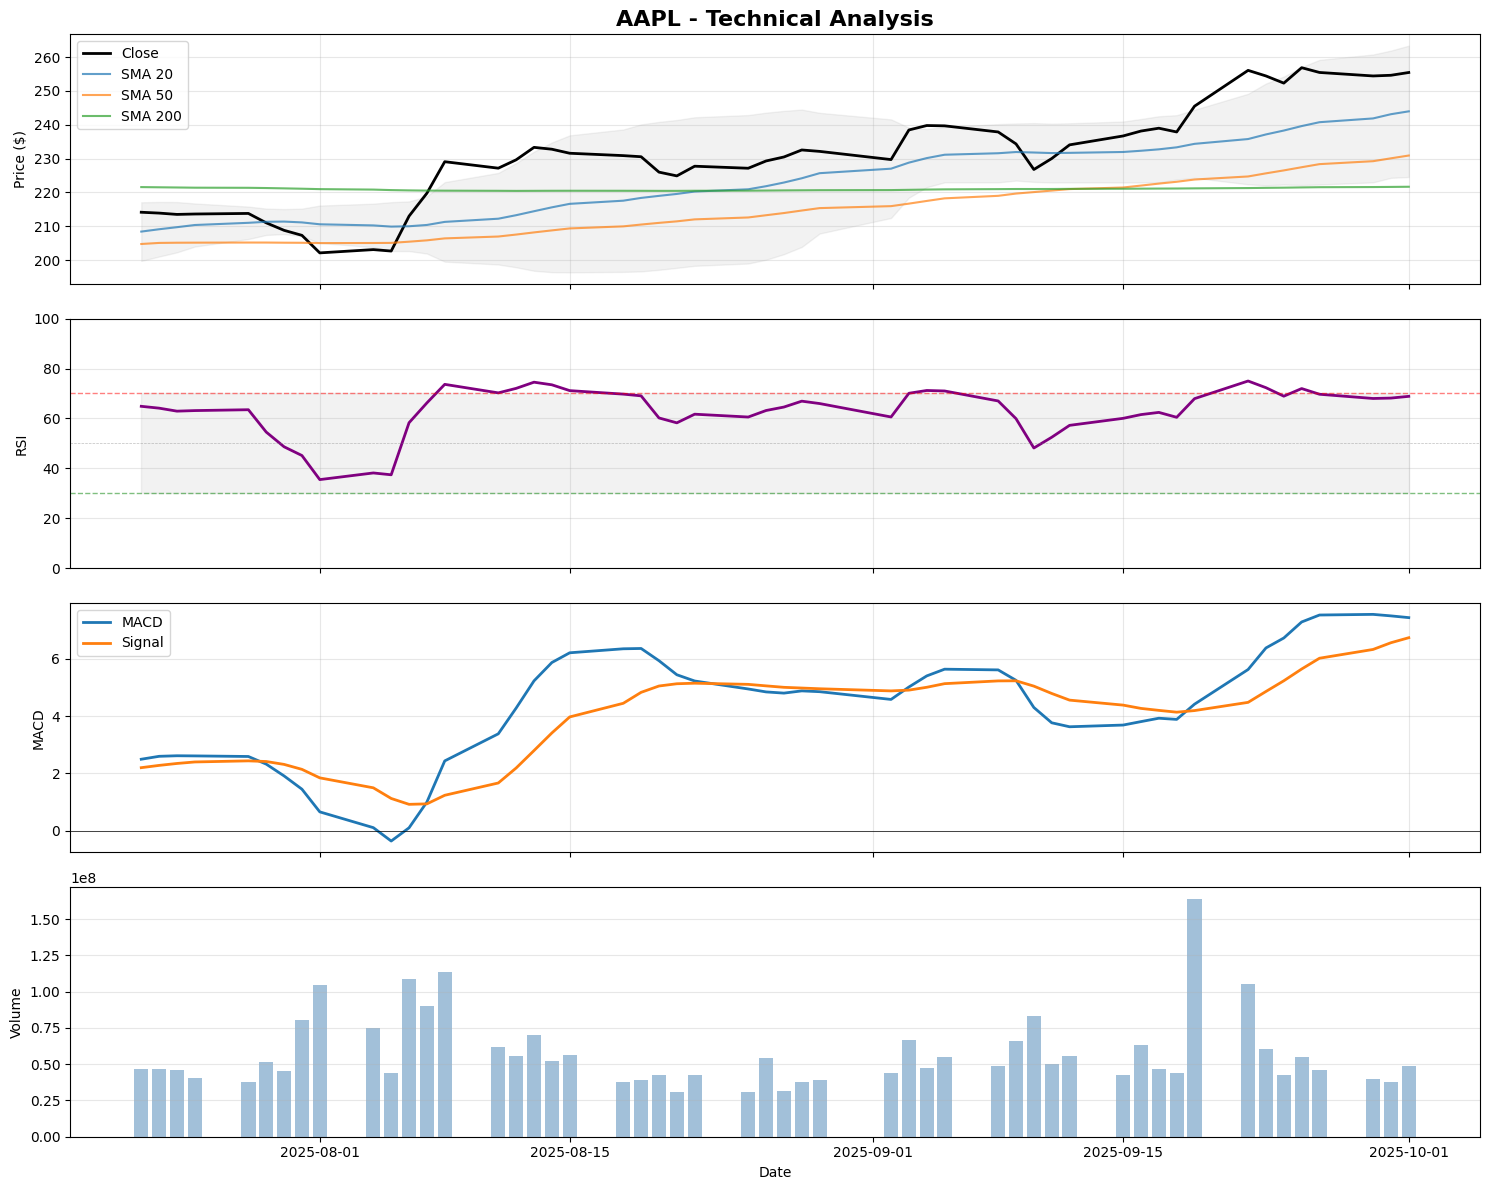

In [26]:
# Plot comprehensive technical analysis for a sample stock
try:
    sample_ticker = 'AAPL'  # You can change this
    
    query_full = f"""
        SELECT 
            t.date,
            p.[close],
            t.sma_20,
            t.sma_50,
            t.sma_200,
            t.rsi_14,
            t.macd,
            t.macd_signal, 
            t.bb_upper,
            t.bb_lower,
            p.volume
        FROM market.technical_indicators t
        JOIN market.daily_prices p ON t.ticker = p.ticker AND t.date = p.date
        WHERE t.ticker = '{sample_ticker}'
        ORDER BY t.date
    """
    
    df_full = db.execute_query(query_full)
    
    if not df_full.empty:
        # Create subplots
        fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)
        
        # 1. Price with Moving Averages
        axes[0].plot(df_full['date'], df_full['close'], label='Close', linewidth=2, color='black')
        axes[0].plot(df_full['date'], df_full['sma_20'], label='SMA 20', linewidth=1.5, alpha=0.7)
        axes[0].plot(df_full['date'], df_full['sma_50'], label='SMA 50', linewidth=1.5, alpha=0.7)
        axes[0].plot(df_full['date'], df_full['sma_200'], label='SMA 200', linewidth=1.5, alpha=0.7)
        axes[0].fill_between(df_full['date'], df_full['bb_lower'], df_full['bb_upper'], alpha=0.1, color='gray')
        axes[0].set_ylabel('Price ($)')
        axes[0].set_title(f'{sample_ticker} - Technical Analysis', fontsize=16, fontweight='bold')
        axes[0].legend(loc='best')
        axes[0].grid(True, alpha=0.3)
        
        # 2. RSI
        axes[1].plot(df_full['date'], df_full['rsi_14'], color='purple', linewidth=2)
        axes[1].axhline(70, color='red', linestyle='--', linewidth=1, alpha=0.5)
        axes[1].axhline(30, color='green', linestyle='--', linewidth=1, alpha=0.5)
        axes[1].axhline(50, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        axes[1].fill_between(df_full['date'], 30, 70, alpha=0.1, color='gray')
        axes[1].set_ylabel('RSI')
        axes[1].set_ylim(0, 100)
        axes[1].grid(True, alpha=0.3)
        
        # 3. MACD
        axes[2].plot(df_full['date'], df_full['macd'], label='MACD', linewidth=2)
        axes[2].plot(df_full['date'], df_full['macd_signal'], label='Signal', linewidth=2)
        axes[2].axhline(0, color='black', linestyle='-', linewidth=0.5)
        axes[2].set_ylabel('MACD')
        axes[2].legend(loc='best')
        axes[2].grid(True, alpha=0.3)
        
        # 4. Volume
        axes[3].bar(df_full['date'], df_full['volume'], color='steelblue', alpha=0.5)
        axes[3].set_ylabel('Volume')
        axes[3].set_xlabel('Date')
        axes[3].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"❌ No data found for {sample_ticker}")
    
except Exception as e:
    print(f"❌ Error creating comprehensive chart: {e}")

2025-10-02 20:28:08,966 - INFO - ✅ Query executed successfully, returned 2 rows


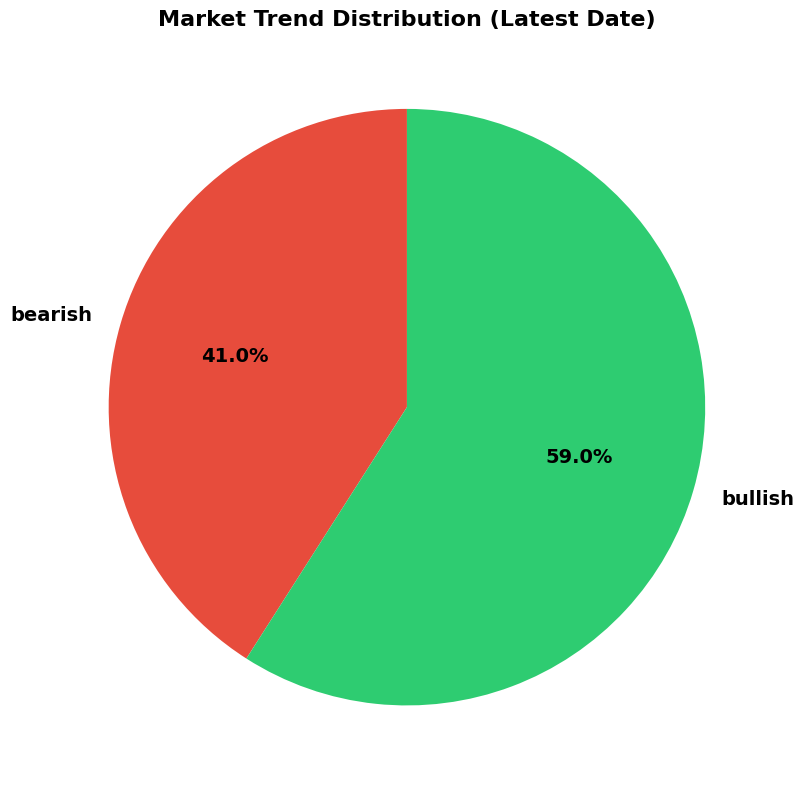


📊 Trend Distribution:
trend_signal  count
     bearish    206
     bullish    297


In [27]:
# Visualize trend signals
try:
    query_trends = """
        SELECT 
            trend_signal,
            COUNT(*) as count
        FROM market.technical_indicators
        WHERE date = (SELECT MAX(date) FROM market.technical_indicators)
        GROUP BY trend_signal
    """
    
    trends_df = db.execute_query(query_trends)
    
    if not trends_df.empty:
        # Create pie chart
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        
        colors = {'bullish': '#2ecc71', 'bearish': '#e74c3c', 'neutral': '#95a5a6'}
        plot_colors = [colors.get(trend, 'gray') for trend in trends_df['trend_signal']]
        
        ax.pie(trends_df['count'], 
               labels=trends_df['trend_signal'], 
               autopct='%1.1f%%',
               colors=plot_colors,
               startangle=90,
               textprops={'fontsize': 14, 'fontweight': 'bold'})
        
        ax.set_title('Market Trend Distribution (Latest Date)', fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\n📊 Trend Distribution:")
        print(trends_df.to_string(index=False))
    
except Exception as e:
    print(f"❌ Error visualizing trends: {e}")

In [28]:
# Generate final summary report
print("=" * 70)
print(" " * 15 + "📊 TECHNICAL INDICATORS SUMMARY")
print("=" * 70)

try:
    # Get comprehensive statistics
    stats = {}
    
    # Total indicators
    result = db.execute_query("SELECT COUNT(*) as count FROM market.technical_indicators")
    stats['total_records'] = result['count'].iloc[0]
    
    # Tickers
    result = db.execute_query("SELECT COUNT(DISTINCT ticker) as count FROM market.technical_indicators")
    stats['total_tickers'] = result['count'].iloc[0]
    
    # Date range
    result = db.execute_query("""
        SELECT 
            MIN(date) as min_date, 
            MAX(date) as max_date,
            COUNT(DISTINCT date) as trading_days
        FROM market.technical_indicators
    """)
    stats['earliest_date'] = result['min_date'].iloc[0]
    stats['latest_date'] = result['max_date'].iloc[0]
    stats['trading_days'] = result['trading_days'].iloc[0]
    
    # Print summary
    print(f"\n📋 CALCULATION RESULTS:")
    print(f"   ✓ Total indicators calculated: {stats['total_records']:,}")
    print(f"   ✓ Tickers processed: {stats['total_tickers']}")
    print(f"   ✓ Success rate: {len(successful_tickers)/len(all_tickers)*100:.1f}%")
    
    print(f"\n📊 DATA COVERAGE:")
    print(f"   ✓ Date range: {stats['earliest_date']} to {stats['latest_date']}")
    print(f"   ✓ Trading days: {stats['trading_days']}")
    print(f"   ✓ Avg records per ticker: {stats['total_records']/stats['total_tickers']:.0f}")
    
    print(f"\n📈 INDICATORS AVAILABLE:")
    print(f"   ✓ Moving Averages (SMA 20/50/200, EMA 12/26)")
    print(f"   ✓ MACD (with signal and histogram)")
    print(f"   ✓ RSI (14-period)")
    print(f"   ✓ Bollinger Bands (20-period)")
    print(f"   ✓ ATR (14-period)")
    print(f"   ✓ Stochastic Oscillator")
    print(f"   ✓ ADX (14-period)")
    print(f"   ✓ Volume indicators (OBV, Volume SMA)")
    print(f"   ✓ Price features (returns, volatility)")
    print(f"   ✓ Trend signals (bullish/bearish/neutral)")
    
    print(f"\n📅 NEXT STEPS:")
    print(f"   1. Use indicators for stock screening (02_stock_screening.ipynb)")
    print(f"   2. Build ML features for return prediction")
    print(f"   3. Create trading signals and strategies")
    print(f"   4. Set up automated indicator updates")
    
    print("=" * 70)
    
except Exception as e:
    print(f"❌ Error generating summary: {e}")

2025-10-02 20:28:18,801 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:28:18,814 - INFO - ✅ Query executed successfully, returned 1 rows
2025-10-02 20:28:18,826 - INFO - ✅ Query executed successfully, returned 1 rows


               📊 TECHNICAL INDICATORS SUMMARY

📋 CALCULATION RESULTS:
   ✓ Total indicators calculated: 25,653
   ✓ Tickers processed: 503
   ✓ Success rate: 100.0%

📊 DATA COVERAGE:
   ✓ Date range: 2025-07-22 to 2025-10-01
   ✓ Trading days: 51
   ✓ Avg records per ticker: 51

📈 INDICATORS AVAILABLE:
   ✓ Moving Averages (SMA 20/50/200, EMA 12/26)
   ✓ MACD (with signal and histogram)
   ✓ RSI (14-period)
   ✓ Bollinger Bands (20-period)
   ✓ ATR (14-period)
   ✓ Stochastic Oscillator
   ✓ ADX (14-period)
   ✓ Volume indicators (OBV, Volume SMA)
   ✓ Price features (returns, volatility)
   ✓ Trend signals (bullish/bearish/neutral)

📅 NEXT STEPS:
   1. Use indicators for stock screening (02_stock_screening.ipynb)
   2. Build ML features for return prediction
   3. Create trading signals and strategies
   4. Set up automated indicator updates


In [29]:
# Close database connection
db.close()
print("✅ Database connection closed")
print("🎉 Technical indicators calculation complete!")

2025-10-02 20:28:31,613 - INFO - 🔌 Database connection closed


✅ Database connection closed
🎉 Technical indicators calculation complete!
